# GTEX Data

https://gtexportal.org/home/

The Genotype-Tissue Expression (GTEx) project is an ongoing effort to build a comprehensive public resource to study tissue-specific gene expression and regulation.

Samples were collected from 54 non-diseased tissue sites across nearly 1000 individuals.

From GTEX we will:
 - download gene expression data in Transcripts Per Million (tpm) for the V8 samples
 - download sample descriptions

## Download GTEX Data - check for downloaded files

GTEXV8_TPM is a large file over 1Gb.

In [ ]:
import os
import pandas as pd
import numpy as np
import pathlib

from logzero import logger
import pickle
from tqdm import tqdm
import requests


# GTEx data from https://gtexportal.org/home/datasets
# Gene transcripts per million data

GTEX_URL =  "https://storage.googleapis.com/gtex_analysis_v8"

GTEXV8_TPM = os.path.join(GTEX_URL, "rna_seq_data", "GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz")
GTEXV8_TPM_MED = os.path.join(GTEX_URL, "rna_seq_data", "GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz")
GTEX_PHENO_DS = os.path.join(GTEX_URL, "annotations", "GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt")
GTEX_PHENO_DD = os.path.join(GTEX_URL, "annotations", "GTEx_Analysis_v8_Annotations_SubjectPhenotypesDD.xlsx")
GTEX_SAMPLE_DS = os.path.join(GTEX_URL, "annotations", "GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt")
GTEX_SAMPLE_DD = os.path.join(GTEX_URL, "annotations", "GTEx_Analysis_v8_Annotations_SampleAttributesDD.xlsx")

script_dir = pathlib.Path().resolve()
cache_dir = os.path.join(script_dir, "data")

if os.path.exists(cache_dir):
    logger.info(f"Found {cache_dir}")
else:
    os.mkdir(cache_dir)

for url in [GTEXV8_TPM_MED, GTEXV8_TPM, GTEX_PHENO_DS, GTEX_PHENO_DD, GTEX_SAMPLE_DS, GTEX_SAMPLE_DD]:
    dest = os.path.join(cache_dir, os.path.basename(url))
    if os.path.exists(dest):
        logger.info(f"found existing: {dest}")
    else:
        logger.info(f"Downloading {dest}")
        # Open a handle onto the GTEx expression data
        response = requests.get(url, stream=True)

        with open(dest, "wb") as fh:
            for data in tqdm(response.iter_content()):
                fh.write(data)
        logger.info(f"Completed {dest}")

[I 210128 10:16:48 <ipython-input-1-04de3e65e59a>:28] Found /home/dustin/fleet_gene/data
[I 210128 10:16:48 <ipython-input-1-04de3e65e59a>:35] found existing: /home/dustin/fleet_gene/data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz
[I 210128 10:16:48 <ipython-input-1-04de3e65e59a>:35] found existing: /home/dustin/fleet_gene/data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz
[I 210128 10:16:48 <ipython-input-1-04de3e65e59a>:35] found existing: /home/dustin/fleet_gene/data/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt
[I 210128 10:16:48 <ipython-input-1-04de3e65e59a>:35] found existing: /home/dustin/fleet_gene/data/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDD.xlsx
[I 210128 10:16:48 <ipython-input-1-04de3e65e59a>:35] found existing: /home/dustin/fleet_gene/data/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt
[I 210128 10:16:48 <ipython-input-1-04de3e65e59a>:35] found existing: /home/dustin/fleet_gene/data/GTEx_Analysis_v8_Annotations_Sample

## Prepare GTEX Data

### Get samples with RNASEQ Expression data

In [ ]:
# Load attributues first
gtex_attr_fn = os.path.join(cache_dir, os.path.basename(GTEX_SAMPLE_DS))
gtex_attr = pd.read_csv(gtex_attr_fn, sep="\t")
gtex_attr.head(2)

SAMPID  SMATSSCR SMCENTER SMPTHNTS  SMRIN   SMTS  \
0  GTEX-1117F-0003-SM-58Q7G       NaN       B1      NaN    NaN  Blood   
1  GTEX-1117F-0003-SM-5DWSB       NaN       B1      NaN    NaN  Blood   

         SMTSD  SMUBRID  SMTSISCH  SMTSPAX  ... SME1ANTI SMSPLTRD SMBSMMRT  \
0  Whole Blood  0013756    1188.0      NaN  ...      NaN      NaN      NaN   
1  Whole Blood  0013756    1188.0      NaN  ...      NaN      NaN      NaN   

  SME1SNSE SME1PCTS SMRRNART SME1MPRT SMNUM5CD  SMDPMPRT  SME2PCTS  
0      NaN      NaN      NaN      NaN      NaN       NaN       NaN  
1      NaN      NaN      NaN      NaN      NaN       NaN       NaN  

[2 rows x 63 columns]

In [ ]:
# Use only the RNASEQ samples
rna_seq_patients = gtex_attr[gtex_attr["SMAFRZE"] == "RNASEQ"]["SAMPID"].tolist()
print(f'Using only RNASEQ {len(rna_seq_patients)} records')

Using only RNASEQ 17382 records


### Choose Subset of samples

Choose a smaller set of samples if you have memory errors.

In [ ]:
# Choose a random sample of 1/5 the patients
import random
random.seed(42)

# Choose a smaller set of samples if you have memory errors.
GTEX_FRAC = 0.2

patient_list = random.sample(rna_seq_patients, int(len(rna_seq_patients) * GTEX_FRAC))

# Leaves a reserve list for validating with later.
reserve_patients = [patient for patient in rna_seq_patients if patient not in patient_list]

print(f'Total of {len(patient_list)} patients as {GTEX_FRAC} of GTEX RNASEQ samples.')
print(f'Using {len(patient_list)} RNASEQ patients with a reserve of {len(reserve_patients)})')

Total of 3476 patients as 0.2 of GTEX RNASEQ samples.
Using 3476 RNASEQ patients with a reserve of 13906)


In [ ]:
gtex_tpm_fn = os.path.join(cache_dir, os.path.basename(GTEXV8_TPM))
logger.info(f"Starting g8 load of {len(patient_list)} samples from {gtex_tpm_fn}")

_g8 = pd.read_csv(
        gtex_tpm_fn,
        skiprows=2,  # First 2 rows are comments of file size - other func here to select genes
        sep='\t',
        header=0,
        usecols=["Description"] + patient_list,  # Number of samples limit
    )

logger.info("\tfinished g8 load")
_g8.info()

[I 210128 10:16:49 <ipython-input-5-4439faf75cf5>:2] Starting g8 load of 3476 samples from /home/dustin/fleet_gene/data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz
[I 210128 10:19:00 <ipython-input-5-4439faf75cf5>:12] 	finished g8 load


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56200 entries, 0 to 56199
Columns: 3477 entries, Description to GTEX-ZZPU-2226-SM-5EGIV
dtypes: float64(3476), object(1)
memory usage: 1.5+ GB


### Prepare Gene expression DataFrame

In [ ]:
print("Removing ambiguous gene descriptions")
# just remove anything ambiguous
dups = _g8[_g8["Description"].duplicated()]["Description"].to_list()
_g8 = _g8[~(_g8["Description"].isin(dups))]
_g8.info()

Removing ambiguous gene descriptions
<class 'pandas.core.frame.DataFrame'>
Int64Index: 54393 entries, 0 to 56199
Columns: 3477 entries, Description to GTEX-ZZPU-2226-SM-5EGIV
dtypes: float64(3476), object(1)
memory usage: 1.4+ GB


In [ ]:
_g8.head()

Description  GTEX-1117F-1326-SM-5EGHH  GTEX-111CU-0226-SM-5GZXC  \
0      DDX11L1                     0.000                   0.04667   
1       WASH7P                     5.389                   1.82300   
2    MIR6859-1                     0.000                   0.00000   
3  MIR1302-2HG                     0.000                   0.04659   
4      FAM138A                     0.000                   0.03310   

   GTEX-111CU-0726-SM-5GZYD  GTEX-111CU-1126-SM-5EGIM  \
0                   0.06455                   0.00000   
1                   0.95250                   4.45900   
2                   0.00000                   0.00000   
3                   0.00000                   0.00000   
4                   0.03052                   0.04188   

   GTEX-111FC-0526-SM-5GZZ8  GTEX-111FC-0826-SM-5GZWO  \
0                   0.00000                   0.00000   
1                   7.51700                   2.45800   
2                   0.00000                   0.00000   
3                   0.00000                   0.03116   
4                   0.04789                   0.00000   

   GTEX-111FC-1926-SM-5GZYC  GTEX-111VG-0008-SM-5Q5BG  \
0                    0.5085                    0.0000   
1                    5.3240                    0.9979   
2                    0.0000                    0.0000   
3                    0.0000                    0.0000   
4                    0.0000                    0.0000   

   GTEX-111VG-1626-SM-5EGIO  ...  GTEX-ZYY3-1726-SM-5EGH3  \
0                    0.0000  ...                  0.00000   
1                    2.7940  ...                  1.92400   
2                    0.6737  ...                  0.00000   
3                    0.0000  ...                  0.00000   
4                    0.0000  ...                  0.03437   

   GTEX-ZYY3-2626-SM-5N9DH  GTEX-ZZ64-0126-SM-5GZXA  GTEX-ZZ64-1026-SM-5GZXG  \
0                    0.000                  0.00000                  0.00000   
1                    8.027                  5.59400                  4.14000   
2                    0.000                  0.00000                  0.00000   
3                    0.000                  0.05295                  0.05038   
4                    0.000                  0.00000                  0.03579   

   GTEX-ZZ64-1126-SM-5GZXY  GTEX-ZZ64-1226-SM-5E43R  GTEX-ZZPT-2926-SM-5EQ5S  \
0                   0.3920                  0.00000                  0.03126   
1                   4.7030                  2.46600                  3.90700   
2                   0.0000                  0.00000                  0.00000   
3                   0.0559                  0.00000                  0.00000   
4                   0.0000                  0.05597                  0.00000   

   GTEX-ZZPT-3026-SM-5GZXH  GTEX-ZZPU-0526-SM-5E44U  GTEX-ZZPU-2226-SM-5EGIV  
0                  0.01874                  0.04614                    0.000  
1                  2.12300                  2.73300                    1.922  
2                  0.00000                  0.00000                    0.000  
3                  0.00000                  0.09211                    0.000  
4                  0.00000                  0.03272                    0.000  

[5 rows x 3477 columns]

### Swap Row and Columns

For the machine learning tools, we wish to have columns of Genes (features), with rows of samples.

In [ ]:
# Switch to columns of genes and rows of patients
# 'Description' is gene name description - alternate index column is 'Name' for ENSEMBL gene id
_g8.set_index("Description", inplace=True)
_g8.T.head(3)

Description               DDX11L1  WASH7P  MIR6859-1  MIR1302-2HG  FAM138A  \
GTEX-1117F-1326-SM-5EGHH  0.00000  5.3890        0.0      0.00000  0.00000   
GTEX-111CU-0226-SM-5GZXC  0.04667  1.8230        0.0      0.04659  0.03310   
GTEX-111CU-0726-SM-5GZYD  0.06455  0.9525        0.0      0.00000  0.03052   

Description               OR4G4P  OR4G11P    OR4F5  RP11-34P13.7   CICP27  \
GTEX-1117F-1326-SM-5EGHH  0.0613  0.00000  0.05609       0.05006  0.00000   
GTEX-111CU-0226-SM-5GZXC  0.0000  0.00000  0.04395       0.00000  0.05827   
GTEX-111CU-0726-SM-5GZYD  0.0000  0.03958  0.08106       0.03617  0.41910   

Description               ...   MT-ND4   MT-TH  MT-TS2  MT-TL2   MT-ND5  \
GTEX-1117F-1326-SM-5EGHH  ...  32020.0   0.000  0.0000   0.000   2578.0   
GTEX-111CU-0226-SM-5GZXC  ...  29430.0  23.980  2.0520   1.705  11920.0   
GTEX-111CU-0726-SM-5GZYD  ...  19760.0   1.618  0.6306   2.096   7625.0   

Description                MT-ND6   MT-TE   MT-CYB   MT-TT  MT-TP  
GTEX-1117F-1326-SM-5EGHH   1857.0   3.731  18180.0  0.7801  2.272  
GTEX-111CU-0226-SM-5GZXC  16030.0  50.290  24690.0  0.6113  0.000  
GTEX-111CU-0726-SM-5GZYD   9659.0  32.350  16860.0  0.0000  1.641  

[3 rows x 54393 columns]

# One-hot Encode Tissue Categories

At this point we have a table of gene expression per sample, with one column per gene in the sample.

We will add a new column for every tissue type ('Kidney', 'Liver', 'Lung') we want to consider.
The column will only values 1 or 0.  The goal is to have a table of only numbers.

In [ ]:
# one-hot encode the tissue categories - make one column per tissue type with 1/0 type

# get a table of tissue per patient to work with
gtex_attr.head(2)
tissues = gtex_attr.set_index("SAMPID")["SMTS"].astype("category")
tissues

SAMPID
GTEX-1117F-0003-SM-58Q7G               Blood
GTEX-1117F-0003-SM-5DWSB               Blood
GTEX-1117F-0003-SM-6WBT7               Blood
GTEX-1117F-0011-R10a-SM-AHZ7F          Brain
GTEX-1117F-0011-R10b-SM-CYKQ8          Brain
                                    ...     
K-562-SM-E9EZC                   Bone Marrow
K-562-SM-E9EZI                   Bone Marrow
K-562-SM-E9EZO                   Bone Marrow
K-562-SM-E9EZT                   Bone Marrow
K-562-SM-E9EZZ                   Bone Marrow
Name: SMTS, Length: 22951, dtype: category
Categories (31, object): ['Adipose Tissue', 'Adrenal Gland', 'Bladder', 'Blood', ..., 'Testis', 'Thyroid', 'Uterus', 'Vagina']

In [ ]:
# pandas get_dummies creates a one-hot encoded table of the column
tissue_df = pd.get_dummies(tissues, dtype=float)
# print(tissue_df.columns)
tissue_df.head(3)

Adipose Tissue  Adrenal Gland  Bladder  Blood  \
SAMPID                                                                    
GTEX-1117F-0003-SM-58Q7G             0.0            0.0      0.0    1.0   
GTEX-1117F-0003-SM-5DWSB             0.0            0.0      0.0    1.0   
GTEX-1117F-0003-SM-6WBT7             0.0            0.0      0.0    1.0   

                          Blood Vessel  Bone Marrow  Brain  Breast  \
SAMPID                                                               
GTEX-1117F-0003-SM-58Q7G           0.0          0.0    0.0     0.0   
GTEX-1117F-0003-SM-5DWSB           0.0          0.0    0.0     0.0   
GTEX-1117F-0003-SM-6WBT7           0.0          0.0    0.0     0.0   

                          Cervix Uteri  Colon  ...  Prostate  Salivary Gland  \
SAMPID                                         ...                             
GTEX-1117F-0003-SM-58Q7G           0.0    0.0  ...       0.0             0.0   
GTEX-1117F-0003-SM-5DWSB           0.0    0.0  ...       0.0             0.0   
GTEX-1117F-0003-SM-6WBT7           0.0    0.0  ...       0.0             0.0   

                          Skin  Small Intestine  Spleen  Stomach  Testis  \
SAMPID                                                                     
GTEX-1117F-0003-SM-58Q7G   0.0              0.0     0.0      0.0     0.0   
GTEX-1117F-0003-SM-5DWSB   0.0              0.0     0.0      0.0     0.0   
GTEX-1117F-0003-SM-6WBT7   0.0              0.0     0.0      0.0     0.0   

                          Thyroid  Uterus  Vagina  
SAMPID                                             
GTEX-1117F-0003-SM-58Q7G      0.0     0.0     0.0  
GTEX-1117F-0003-SM-5DWSB      0.0     0.0     0.0  
GTEX-1117F-0003-SM-6WBT7      0.0     0.0     0.0  

[3 rows x 31 columns]

In [ ]:
# Merge the two tables, with samples as rows
g8 = _g8.T.merge(tissue_df, how="inner", left_index=True, right_index=True)
del _g8  # Free up memory
g8.info()
g8.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3476 entries, GTEX-1117F-1326-SM-5EGHH to GTEX-ZZPU-2226-SM-5EGIV
Columns: 54424 entries, DDX11L1 to Vagina
dtypes: float64(54424)
memory usage: 1.4+ GB


DDX11L1  WASH7P  MIR6859-1  MIR1302-2HG  FAM138A  \
GTEX-1117F-1326-SM-5EGHH  0.00000  5.3890        0.0      0.00000  0.00000   
GTEX-111CU-0226-SM-5GZXC  0.04667  1.8230        0.0      0.04659  0.03310   
GTEX-111CU-0726-SM-5GZYD  0.06455  0.9525        0.0      0.00000  0.03052   
GTEX-111CU-1126-SM-5EGIM  0.00000  4.4590        0.0      0.00000  0.04188   
GTEX-111FC-0526-SM-5GZZ8  0.00000  7.5170        0.0      0.00000  0.04789   

                           OR4G4P  OR4G11P    OR4F5  RP11-34P13.7   CICP27  \
GTEX-1117F-1326-SM-5EGHH  0.06130  0.00000  0.05609       0.05006  0.00000   
GTEX-111CU-0226-SM-5GZXC  0.00000  0.00000  0.04395       0.00000  0.05827   
GTEX-111CU-0726-SM-5GZYD  0.00000  0.03958  0.08106       0.03617  0.41910   
GTEX-111CU-1126-SM-5EGIM  0.12160  0.16290  0.00000       0.07446  0.08848   
GTEX-111FC-0526-SM-5GZZ8  0.06949  0.00000  0.06359       0.02838  0.01686   

                          ...  Prostate  Salivary Gland  Skin  \
GTEX-1117F-1326-SM-5EGHH  ...       0.0             0.0   0.0   
GTEX-111CU-0226-SM-5GZXC  ...       0.0             0.0   0.0   
GTEX-111CU-0726-SM-5GZYD  ...       0.0             0.0   0.0   
GTEX-111CU-1126-SM-5EGIM  ...       0.0             0.0   1.0   
GTEX-111FC-0526-SM-5GZZ8  ...       0.0             0.0   0.0   

                          Small Intestine  Spleen  Stomach  Testis  Thyroid  \
GTEX-1117F-1326-SM-5EGHH              0.0     0.0      0.0     0.0      0.0   
GTEX-111CU-0226-SM-5GZXC              0.0     0.0      0.0     0.0      1.0   
GTEX-111CU-0726-SM-5GZYD              0.0     0.0      0.0     0.0      0.0   
GTEX-111CU-1126-SM-5EGIM              0.0     0.0      0.0     0.0      0.0   
GTEX-111FC-0526-SM-5GZZ8              0.0     0.0      0.0     0.0      0.0   

                          Uterus  Vagina  
GTEX-1117F-1326-SM-5EGHH     0.0     0.0  
GTEX-111CU-0226-SM-5GZXC     0.0     0.0  
GTEX-111CU-0726-SM-5GZYD     0.0     0.0  
GTEX-111CU-1126-SM-5EGIM     0.0     0.0  
GTEX-111FC-0526-SM-5GZZ8     0.0     0.0  

[5 rows x 54424 columns]

# ML Imports

In [ ]:
from fastai.tabular.all import (L, F, Categorify, FillMissing, Normalize, TabularPandas,
                                cont_cat_split, save_pickle, load_pickle, tabular_learner, tensor)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from dtreeviz.trees import dtreeviz
from fastbook import cluster_columns, draw_tree
import matplotlib.pyplot as plt

# Setup fastai Training Object Helper

Automatic choices and cleanup can be helpful.

In [ ]:
# Find continuous and categorical columns
# gene TPM (transcripts per million) would be a continuous range

# The dependent variable we wish to find is the tissue type.
dep_var = list(tissue_df.columns)

# continous variables can have a range of values, like the gene TPMs
# categorical variables only have specific levels.
cont, cat = cont_cat_split(g8, max_card=500, dep_var=dep_var)

int_index = range(len(g8))
# random, even split of training and validation.  Most experiments use 80% of the data to train.
train_idx = random.sample(int_index, int(len(int_index) * 0.5))
valid_idx = [i for i in int_index if i not in train_idx]

In [ ]:
train_ob = TabularPandas(g8, procs=[FillMissing, Categorify], cat_names=cat,
                         cont_names=cont, y_names=dep_var, splits=(train_idx, valid_idx))

In [ ]:
train_ob.show(2)

In [ ]:
train_ob.y_names

(#31) ['Adipose Tissue','Adrenal Gland','Bladder','Blood','Blood Vessel','Bone Marrow','Brain','Breast','Cervix Uteri','Colon'...]

In [ ]:
# These object can be saved and loaded with pickle
save_pickle(os.path.join(cache_dir, "train_ob_tissue.pkl"), train_ob)

## Function to Measure Success

In [ ]:
def accuracy(inp, targ, axis=-1):
    "Compute fraction of correctly called targets."
    pred = tensor(inp).argmax(dim=axis)  # Find the largest value prediction.
    target = tensor(targ).argmax(dim=axis)  # Find one-hot encoded value
    return float((pred == target).float().mean())


def rf_accuracy(m, xs, ys):
    return accuracy(m.predict(xs), ys)


# Random Forest

The 'Random Forest' refers to a 'forest' of Decision Trees.

A large collection of decision trees is made using:
 - a random set of features (gene expression values in our case)
 - a random set of samples
 
 Then, using this forest of decision trees, the concensus of the ensembl is assumed to be right.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create a DecisionTreeClassifier for the first tissue type
m = DecisionTreeClassifier(max_leaf_nodes=4, min_samples_leaf=50)
m.fit(train_ob.train.xs, train_ob.train.y)

DecisionTreeClassifier(max_leaf_nodes=4, min_samples_leaf=50)

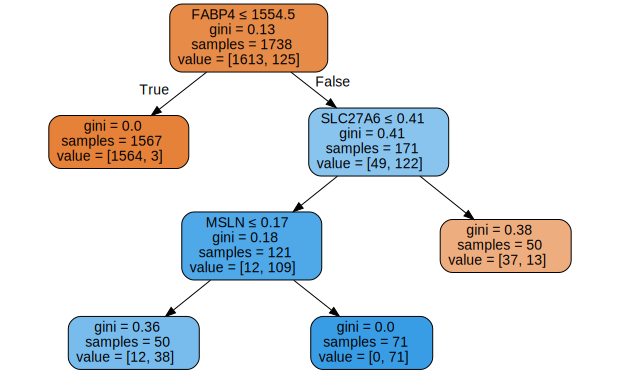

In [ ]:
draw_tree(m, train_ob.train.xs, size=10, leaves_parallel=False, precision=2)

## Random Forest Model

In [ ]:
def rf(xs, ys, n_estimators=40, max_samples=None,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    """Random Forest setup helper with some standard parameters"""
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, ys)

In [ ]:
# Some convenience variables

valid_xs = train_ob.valid.xs
valid_ys = train_ob.valid.ys
xs = train_ob.train.xs
ys = train_ob.train.ys

In [ ]:
# We have a over 54 thousand genes
train_ob.x_names

(#54393) ['DDX11L1','WASH7P','MIR6859-1','MIR1302-2HG','FAM138A','OR4G4P','OR4G11P','OR4F5','RP11-34P13.7','CICP27'...]

## Random Forests with Different Numbers of genes

[I 210128 10:19:49 <ipython-input-24-729d295e893c>:14] Starting traing log2 genes with 50 estimators


CPU times: user 14.3 s, sys: 578 ms, total: 14.9 s
Wall time: 13 s


[I 210128 10:20:03 <ipython-input-24-729d295e893c>:16] 	 'log2' train, valid: (tensor(0.8867), tensor(0.7969))
[I 210128 10:20:14 <ipython-input-24-729d295e893c>:14] Starting traing sqrt genes with 50 estimators


CPU times: user 27.4 s, sys: 117 ms, total: 27.5 s
Wall time: 13.7 s


[I 210128 10:20:29 <ipython-input-24-729d295e893c>:16] 	 'sqrt' train, valid: (tensor(0.9563), tensor(0.9091))
[I 210128 10:20:40 <ipython-input-24-729d295e893c>:14] Starting traing 0.2 genes with 50 estimators


CPU times: user 13min 32s, sys: 79.1 ms, total: 13min 32s
Wall time: 1min 58s


[I 210128 10:22:40 <ipython-input-24-729d295e893c>:16] 	 '0.2' train, valid: (tensor(0.9896), tensor(0.9603))


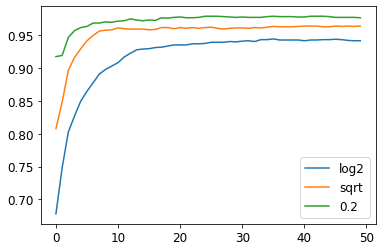

In [ ]:
#'features' are genes to use
max_feature_list = [
    'log2',
    'sqrt', # default
    #0.1,
    0.2,
    #0.5,  # fraction of features to use.  Half.
    #None,  # Use all features
]
m_dict = {}

ESTIMATORS = 50
for mf in max_feature_list:
    logger.info(f"Starting traing {mf} genes with {ESTIMATORS} estimators")
    %time m = rf(xs, ys, n_estimators=ESTIMATORS, max_features=mf)
    logger.info(f"\t '{mf}' train {rf_accuracy(m, xs, ys)}, valid: {rf_accuracy(m, valid_xs, valid_ys)}")
    preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
    plt.plot([accuracy(tensor(preds[:i+1].mean(0)), valid_ys) for i in range(ESTIMATORS)])
plt.legend([str(i) for i in max_feature_list])

A greater number of features (gene expressions) helps the predictions.
Seem to be diminishing returns after about 10% (~ 5.5k genes)

## Test Running a prediction

### Example - first validation sample

In [ ]:
# Just using the first sample of the validation set as an example
valid_xs.iloc[0]

DDX11L1            0.0000
WASH7P             5.3890
MIR6859-1          0.0000
MIR1302-2HG        0.0000
FAM138A            0.0000
                  ...    
MT-ND6          1857.0000
MT-TE              3.7310
MT-CYB         18180.0000
MT-TT              0.7801
MT-TP              2.2720
Name: GTEX-1117F-1326-SM-5EGHH, Length: 54393, dtype: float32

In [ ]:
valid_ys.iloc[0]

Adipose Tissue     1.0
Adrenal Gland      0.0
Bladder            0.0
Blood              0.0
Blood Vessel       0.0
Bone Marrow        0.0
Brain              0.0
Breast             0.0
Cervix Uteri       0.0
Colon              0.0
Esophagus          0.0
Fallopian Tube     0.0
Heart              0.0
Kidney             0.0
Liver              0.0
Lung               0.0
Muscle             0.0
Nerve              0.0
Ovary              0.0
Pancreas           0.0
Pituitary          0.0
Prostate           0.0
Salivary Gland     0.0
Skin               0.0
Small Intestine    0.0
Spleen             0.0
Stomach            0.0
Testis             0.0
Thyroid            0.0
Uterus             0.0
Vagina             0.0
Name: GTEX-1117F-1326-SM-5EGHH, dtype: float32

In [ ]:
# single prediction of a set
pred = m.predict(valid_xs.iloc[0:1])[0]
pred

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
# See the tissue predicted
tissue_index = pred.argmax()
dep_var[tissue_index]

'Adipose Tissue'

### Example of a failed prediction

In [ ]:
# Find an example of a failed prediction

rf_preds = m.predict(valid_xs)

for i, pred in enumerate(rf_preds):
    p_call = pred.argmax()
    t_call = valid_ys.iloc[i].argmax()
    if p_call != t_call:
        if p_call.max():  # most failures are no predictions (all zeros)
            break

print(f"predicted valid_xs[{i}] as: {dep_var[p_call]}")
print(f"\tActually is: {dep_var[t_call]}")

predicted valid_xs[314] as: Esophagus
	Actually is: Stomach


## Feature Importance

Random Forests have a property .feature_importances_ showing which genes have a large effect on classification.

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(m, xs)
fi[:20]

cols       imp
12606         NKX6-1  0.046180
41371     AC004158.3  0.030578
15772           PSD2  0.027596
28791         NLRP10  0.025936
45458       SERPINB7  0.025671
20645           GRM3  0.018849
23294          FABP4  0.017892
464           FBLIM1  0.015555
49900      LINC00320  0.015444
463    RP11-169K16.4  0.014409
48147          TNNI3  0.012780
3900           TNNT2  0.011612
20608           CD36  0.010780
45396  RP11-824M15.3  0.010167
13352        MAB21L2  0.010073
27796         OPALIN  0.009698
29359         MYBPC3  0.009689
25989       MIR219A2  0.009606
3089         C1orf61  0.009290
49128    RP4-616B8.5  0.008415

<AxesSubplot:ylabel='cols'>

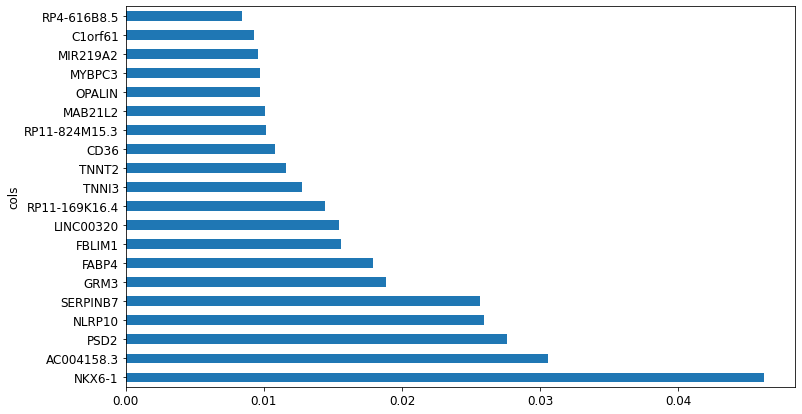

In [ ]:
fi[:20].plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

A common action would be to try to drop features of low importance, and see if models build using less genes are still as accurate.

# Neural Network

The fastai TabularPandas training object

In [ ]:
learn = tabular_learner(
    train_ob.dataloaders(batch_size=512),  # Use smaller batchsizes to avoid memory errors
    y_range=(0, 1),      # Our 'tissueness' scores should range between 0-1
    layers=[500, 250],   # Default layers are [200, 100]
    n_out=len(dep_var),  # One score per tissue
    metrics=accuracy,
)

In [ ]:
learn.summary()

TabularModel (Input shape: 512 x torch.Size([512, 54393]))
Layer (type)         Output Shape         Param #    Trainable 
                     512 x 54393         
BatchNorm1d                               108786     True      
BatchNorm1d                               108786     True      
____________________________________________________________________________
                     512 x 500           
Linear                                    27196500   True      
ReLU                                                           
BatchNorm1d                               1000       True      
____________________________________________________________________________
                     512 x 250           
Linear                                    125000     True      
ReLU                                                           
____________________________________________________________________________
                     512 x 31            
Linear                        

## Find a learning rate parameter

We want a learning rate at the steepest slope - most improvement per step.
Too small and learning takes longer.
Too large and the results will not converge.

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.010964781977236271)

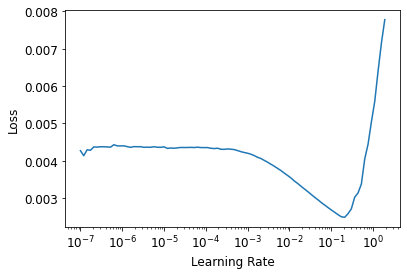

In [ ]:
learn.lr_find()

## Train the Neural Network

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-3)

### Watch for overfitting
With Neural Nets - watch out for over-fitting.
 - training set loss keeps dropping, but validation gets worse
 - means the neural network has learned idiosyncrasies that do not generalize.

In [ ]:
learn.fit_one_cycle(20, 1e-3)

## Example Prediction

Check our call on the first sample of the validation set

In [ ]:
full_dec,dec_pred,pred = learn.predict(valid_xs.iloc[0])

<AxesSubplot:>

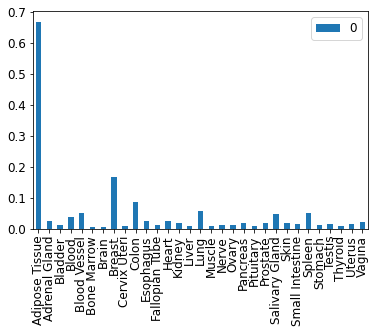

In [ ]:
def plot_pred(pred):
    pred_df = pd.DataFrame(pred)
    pred_df.index = dep_var
    return pred_df.plot.bar()

plot_pred(pred)

In [ ]:
valid_ys.iloc[0]

Adipose Tissue     1.0
Adrenal Gland      0.0
Bladder            0.0
Blood              0.0
Blood Vessel       0.0
Bone Marrow        0.0
Brain              0.0
Breast             0.0
Cervix Uteri       0.0
Colon              0.0
Esophagus          0.0
Fallopian Tube     0.0
Heart              0.0
Kidney             0.0
Liver              0.0
Lung               0.0
Muscle             0.0
Nerve              0.0
Ovary              0.0
Pancreas           0.0
Pituitary          0.0
Prostate           0.0
Salivary Gland     0.0
Skin               0.0
Small Intestine    0.0
Spleen             0.0
Stomach            0.0
Testis             0.0
Thyroid            0.0
Uterus             0.0
Vagina             0.0
Name: GTEX-1117F-1326-SM-5EGHH, dtype: float32

# Comparing the Neural Network and Random Forest Models

In [ ]:
nn_preds, targs = learn.get_preds()
accuracy(nn_preds, targs)

0.9131185412406921

In [ ]:
# Find some interesting cases to compare
nn_better = []
rf_better = []
both_fail = []
for i, (pred_rf, pred_nn) in enumerate(zip(rf_preds, nn_preds)):
    tissue_idx = valid_ys.iloc[i].argmax()
    pred_rf_idx = pred_rf.argmax()
    pred_nn_idx = pred_nn.argmax()
    if pred_rf_idx != tissue_idx and pred_nn_idx != tissue_idx:
        # print(f'both failed {i}')
        both_fail.append(i)
    elif pred_rf_idx != tissue_idx and pred_nn_idx == tissue_idx:
        nn_better.append(i)
        # print(f'nn only {i}')
        if pred_rf.max():
            break
    elif pred_rf_idx == tissue_idx and pred_nn_idx != tissue_idx:
        rf_better.append(i)
        # print(f'rf only {i}')

rf only 7
rf only 24
rf only 47
rf only 59
rf only 70
both failed 88
both failed 110
both failed 131
rf only 143
rf only 184
nn only 196
rf only 242
both failed 282
both failed 311
both failed 314
rf only 328
rf only 332
both failed 341
rf only 345
both failed 346
rf only 356
rf only 380
rf only 390
rf only 408
rf only 412
both failed 418
nn only 430
rf only 436
rf only 437
both failed 442
both failed 479
both failed 486
rf only 490
rf only 495
both failed 497
rf only 521
rf only 538
nn only 542
both failed 586
rf only 591
rf only 594
both failed 599
rf only 601
both failed 630
rf only 639
both failed 665
rf only 690
rf only 698
nn only 758


In [ ]:
# test on an example where the random forest failed.
idx = nn_better[-1]
_,_,prednn = learn.predict(valid_xs.iloc[idx])

tensor([0.1389, 0.1202, 0.0267, 0.0831, 0.0393, 0.0152, 0.0184, 0.0855, 0.0231, 0.1016, 0.0673, 0.0243, 0.1811, 0.0300, 0.0535, 0.0263, 0.0769, 0.0264, 0.0268, 0.1132, 0.0134, 0.0345, 0.0599, 0.0290,
        0.0386, 0.0302, 0.1965, 0.0285, 0.0174, 0.0259, 0.0329])


<AxesSubplot:>

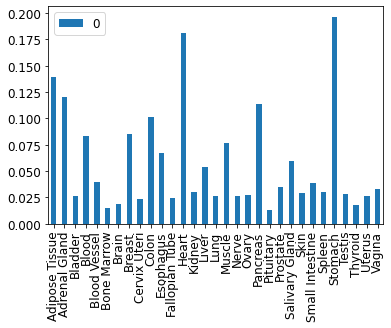

In [ ]:
print(dep_var[valid_ys.iloc[idx].argmax()])
print(prednn)
plot_pred(prednn)

<AxesSubplot:>

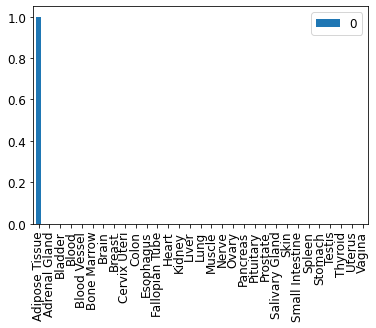

In [ ]:
predrf = tensor(m.predict(valid_xs.iloc[idx:idx+1]))[0]
plot_pred(predrf)

<AxesSubplot:>

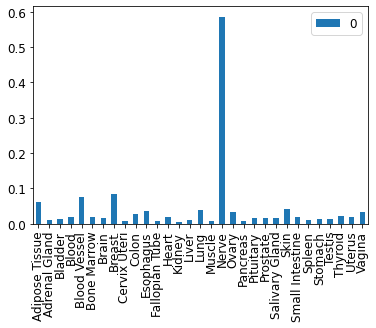

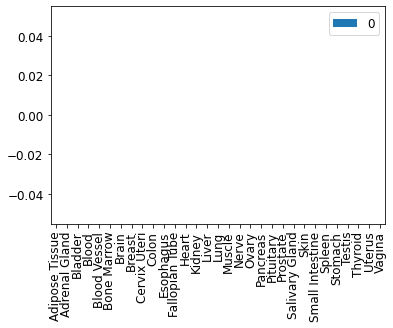

In [ ]:
# Most cases of the Randomw forest failure have no prediction from the random forest
plot_pred(rf_preds[nn_better[0]])
plot_pred(nn_preds[nn_better[0]])

## Combine the Calls

By just adding up the scores, the neural net fills in blanks of the Random Forest.

In [ ]:
print(accuracy(rf_preds, valid_ys))
print(accuracy(nn_preds, valid_ys))

0.9602991938591003
0.9131185412406921


In [ ]:
comb_preds = (tensor(rf_preds)) + tensor(nn_preds)
accuracy(comb_preds, valid_ys)

0.9654775857925415

In [ ]:
preds_std = rf_preds.std(0)

In [ ]:
m.oob_score_

0.9978284271873494

In [ ]:

%load_ext memory_profiler
%memit

import sys

def show_large_mem_users(max_num=10):
    return sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules],
                  key=lambda x: x[1], reverse=True)[:max_num]
mems = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules],
                  key=lambda x: x[1], reverse=True)

peak memory: 8579.89 MiB, increment: 0.04 MiB


In [ ]:
from datetime import datetime
datetime.now().strftime("%Y%m%d_%H%M")


'20210128_1024'

In [ ]:
learn.summary()

TabularModel (Input shape: 512 x torch.Size([512, 54393]))
Layer (type)         Output Shape         Param #    Trainable 
                     512 x 54393         
BatchNorm1d                               108786     True      
BatchNorm1d                               108786     True      
____________________________________________________________________________
                     512 x 500           
Linear                                    27196500   True      
ReLU                                                           
BatchNorm1d                               1000       True      
____________________________________________________________________________
                     512 x 250           
Linear                                    125000     True      
ReLU                                                           
____________________________________________________________________________
                     512 x 31            
Linear                        

In [ ]:
# pickle.dump(m, open(os.path.join(cache_dir, "rf_all_genes.pkl"), "wb"))
# pickle.dump(learn, open(os.path.join(cache_dir, f'nn_{datetime.now().strftime("%Y%m%d_%H%M")}.pkl'), "wb"))